In [1]:
import pandas as pd
import missingno as msno
import codecs
import bs4

In [68]:
file = codecs.open('untitled.txt', 'r', 'utf-8')
file = bs4.BeautifulSoup(file, 'html.parser')
allusers = file.findAll('review')

enlist = []
locallist = []

for user in allusers:
# user name
    # record comments
    try:
        enlist.append(user.findAll('text-with-highlights')[1].text.strip())
        locallist.append(user.findAll('text-with-highlights')[0].text.strip())
    # No Translated comments
    except:
        enlist.append(user.findAll('text-with-highlights')[0].text.strip())
        locallist.append(user.findAll('text-with-highlights')[0].text.strip())

# to framework
df = pd.DataFrame()
df['en'] = enlist
df['local'] = locallist

df.head()

,en,local
0,"Hello, I only put 1 stars why it is not in .. ...",Hola.solo pongo 1 estrellas por qué no está en...
1,It is difficult to find items because of searc...,因為搜尋任務很難找到物品 下一個版本什麼時候會出現? 沼澤和出航任務什麼時候會來?
2,Please fix the bugs. Dinosaurs and others can'...,Please fix the bugs. Dinosaurus dan lainnya ti...
3,"Loved the game, even spend some money, but tod...","Loved the game, even spend some money, but tod..."
4,The game wont open.... frustrating i spent a l...,The game wont open.... frustrating i spent a l...


<AxesSubplot:>

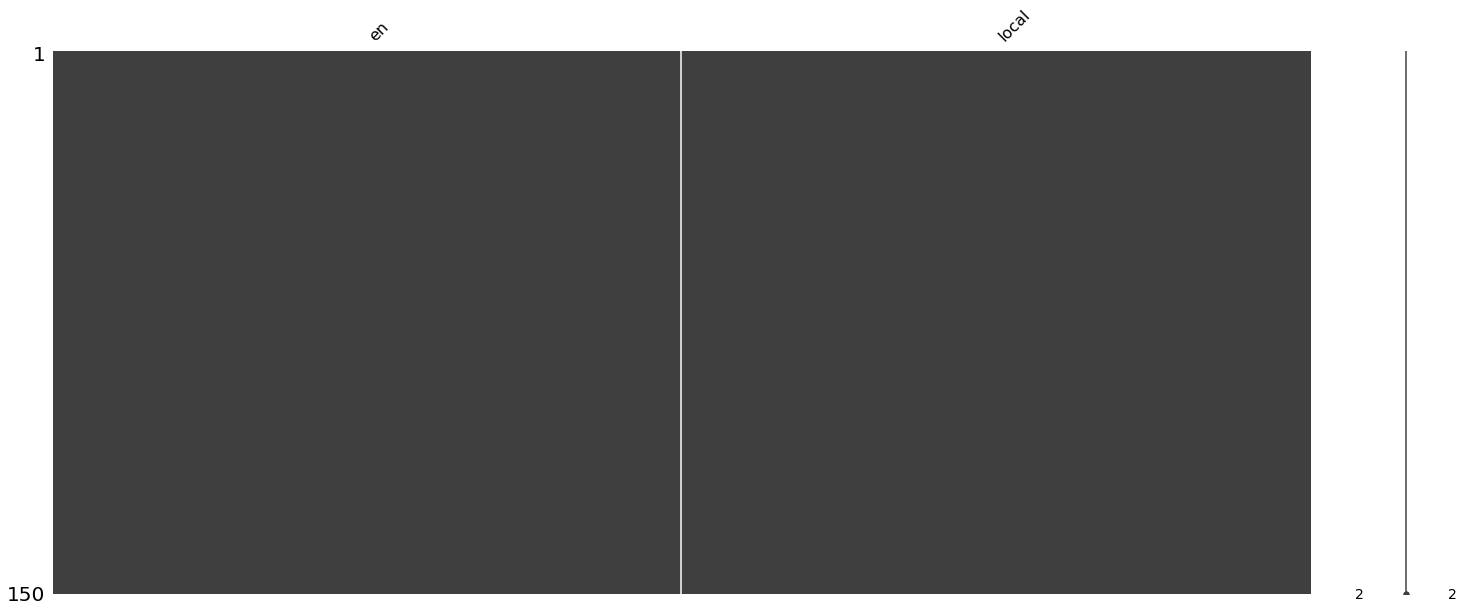

In [70]:
msno.matrix(df)

In [71]:
df.isna().sum()

en       0
local    0
dtype: int64

In [72]:
df['en'] = df['en'].str.lower()
comment_words = " ".join(df['en'].values)
comment_words[:100]

'hello, i only put 1 stars why it is not in .. spanish .. i ask when ... it is difficult to find item'

In [74]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

In [78]:
len(STOPWORDS)

192

In [82]:
# STOPWORDS.update(['game', 'paly','please'])
# STOPWORDS.add('please')
# len(STOPWORDS)

195

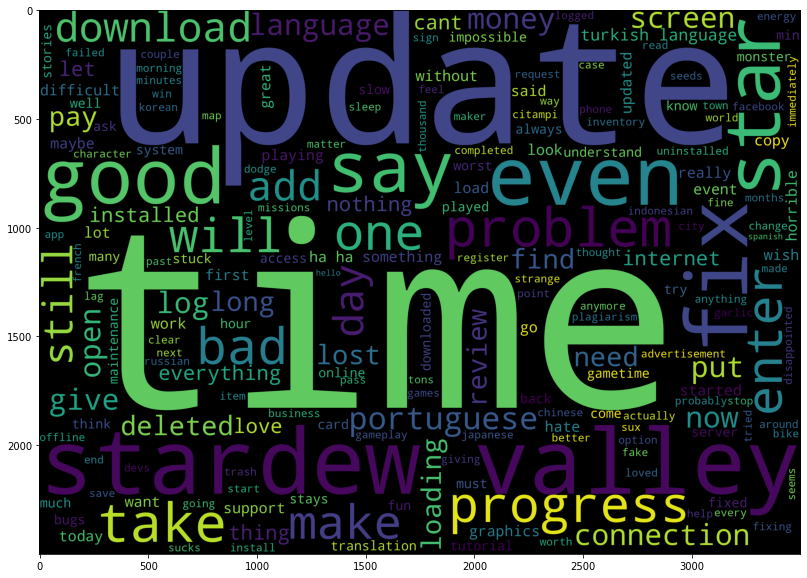

In [83]:
wordcloud = WordCloud(width = 3500, height = 2500, random_state = None,
                     stopwords = STOPWORDS).generate(comment_words)

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.show()

In [19]:
import pickle as pk
from scipy import sparse as sp

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [84]:
tokenizer = RegexpTokenizer(r'\w+')

In [85]:
texts = df['en']

In [86]:
texts = texts.str.lower()
for idx in range(len(texts)):
    texts[idx] = tokenizer.tokenize(texts[idx])  # Split into words.

In [87]:
# Remove numbers, but not words that contain numbers.
texts = [[token for token in doc if not token.isdigit()] for doc in texts]

In [88]:
# Remove words that are only one character.
texts = [[token for token in doc if len(token) > 3] for doc in texts]

In [89]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [90]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dave/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [91]:
# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
texts = [[lemmatizer.lemmatize(token) for token in doc] for doc in texts] 

In [92]:
from gensim.models import Phrases

In [93]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(texts, min_count=10)
trigram = Phrases(bigram[texts])

In [94]:
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)
    for token in trigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

In [95]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 615
Number of unique words after removing rare and common words: 17


In [96]:
corpus = [dictionary.doc2bow(doc) for doc in texts]

In [97]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 17
Number of documents: 150


In [98]:
from gensim.models import LdaModel

In [99]:
# Set training parameters.
num_topics = 4
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

CPU times: user 1.16 s, sys: 15.6 ms, total: 1.17 s
Wall time: 1.19 s


In [100]:
import pyLDAvis
# import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import warnings

In [101]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [102]:
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

/home/dave/program/anaconda3/envs/lang/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.105455 -0.066197       1        1  31.751548
1      0.304434 -0.023618       2        1  25.468329
0     -0.124200 -0.140137       3        1  23.237452
2     -0.074779  0.229952       4        1  19.542671, topic_info=              Term       Freq      Total Category  logprob  loglift
14  stardew_valley  31.000000  31.000000  Default  17.0000  17.0000
8             play  28.000000  28.000000  Default  16.0000  16.0000
9             that  35.000000  35.000000  Default  15.0000  15.0000
6             what  13.000000  13.000000  Default  14.0000  14.0000
15          valley  16.000000  16.000000  Default  13.0000  13.0000
..             ...        ...        ...      ...      ...      ...
13         stardew   0.238809  16.221509   Topic4  -5.5895  -2.5859
4           update   0.239922  17.282218   Topic4  -5.5848  -2.6445
1             when   0.246280  20.067398   Topic4  -5.5587  -2.7678
8             play   0.270636  28.253063   Topic4  -5.4644  -3.0156
14  stardew_valley   0.238806  31.493730   Topic4  -5.5895  -3.2493

[85 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3         1  0.301161            even
3         2  0.150580            even
3         3  0.451741            even
11        1  0.163112            good
11        3  0.734002            good
12        1  0.522690            just
12        2  0.373350            just
12        3  0.074670            just
7         1  0.166639            like
7         2  0.166639            like
7         3  0.166639            like
7         4  0.499917            like
8         1  0.141578            play
8         3  0.849465            play
2         1  0.976519          please
0         1  0.485447            star
0         2  0.080908            star
0         3  0.323632            star
0         4  0.080908            star
13        2  0.986345         stardew
14        2  0.984323  stardew_valley
9         2  0.083694            that
9         3  0.278980            that
9         4  0.641653            that
10        2  0.075932           there
10        3  0.835253           there
16        1  0.653770            this
16        2  0.130754            this
16        4  0.228820            this
5         1  0.450444            time
5         3  0.050049            time
5         4  0.500494            time
4         1  0.983670          update
15        2  0.986345          valley
6         4  0.908072            what
1         1  0.747481            when
1         3  0.199328            when, R=17, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

In [105]:
df['tokenz'] = texts

docs1 = df['tokenz'].apply(lambda l: l[:int(len(l)/2)])
docs2 = df['tokenz'].apply(lambda l: l[int(len(l)/2):])

In [106]:
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = model[corpus1]
lda_corpus2 = model[corpus2]

In [107]:
from collections import OrderedDict

In [119]:
import numpy as np

In [122]:
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

In [127]:
top_dist1, _ = get_doc_topic_dist(model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(df['en']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.9109323
Inter similarity: cosine similarity between random parts (lower is better):
0.8658152


In [129]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [130]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

play                 0.314
there                0.150
that                 0.127
good                 0.124
even                 0.083
star                 0.059
when                 0.058
like                 0.042
just                 0.011
time                 0.010
Topic 1 |---------------------

stardew_valley       0.370
valley               0.186
stardew              0.186
just                 0.064
this                 0.045
that                 0.039
like                 0.034
even                 0.029
there                0.015
star                 0.007
Topic 2 |---------------------

that                 0.355
what                 0.195
time                 0.151
like                 0.134
this                 0.105
star                 0.018
play                 0.004
when                 0.004
just                 0.004
there                0.004
Topic 3 |---------------------

this                 0.192
upd